# Gramener Case Study

In [1]:
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_columns = 20

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

#### External contants

In [3]:
loan_file_path="./loan/loan.csv"
data_dict_file_path = "./loan/Data_Dictionary.xlsx"

## Check Point 1:  Data Cleaning

### - Fetching ```loan``` data from given file

In [4]:
pd.options.display.max_columns = 20
loan = pd.read_csv(loan_file_path, encoding="utf8", low_memory=False)
loan.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.000,36 months,10.65%,162.870,B,B2,...,nan,nan,nan,nan,0.000,0.000,nan,nan,nan,nan
1,1077430,1314167,2500,2500,2500.000,60 months,15.27%,59.830,C,C4,...,nan,nan,nan,nan,0.000,0.000,nan,nan,nan,nan
2,1077175,1313524,2400,2400,2400.000,36 months,15.96%,84.330,C,C5,...,nan,nan,nan,nan,0.000,0.000,nan,nan,nan,nan
3,1076863,1277178,10000,10000,10000.000,36 months,13.49%,339.310,C,C1,...,nan,nan,nan,nan,0.000,0.000,nan,nan,nan,nan
4,1075358,1311748,3000,3000,3000.000,60 months,12.69%,67.790,B,B5,...,nan,nan,nan,nan,0.000,0.000,nan,nan,nan,nan


#### Finding number of rows and columns in the dataset

In [5]:
print('The loan dataset set has %d rows and %d columns' % (loan.shape[0], loan.shape[1]))

The loan dataset set has 39717 rows and 111 columns


#### Removing columns which have all values as ```NaN```

In [6]:
nan_count_df = loan.isnull().sum().to_frame('nan_count')
num_col_with_all_nan = nan_count_df.loc[nan_count_df['nan_count']  == loan.shape[0], :].shape[0]
print('Number of columns with all NaN values are %d.' % (num_col_with_all_nan))

Number of columns with all NaN values are 54.


In [7]:
# Removing columns which have all values as NaN
loans_frame = loan.dropna(axis=1, how="all")
print('The loan dataset set has now %d rows and %d columns' % (loans_frame.shape[0], loans_frame.shape[1]))

The loan dataset set has now 39717 rows and 57 columns


### - Fetching ```Data Dictionary```  from given file

In [8]:
data_dict = pd.read_excel(data_dict_file_path, sheet_name="LoanStats")
data_dict.head()

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower is now delinquent.
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan application
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by the borrower during registration.


#### Initial List of columns for consideration 

In [9]:
filtered_data_dict = data_dict.loc[data_dict['LoanStatNew'].isin(loans_frame.columns), :]

### Considering those loan entries which are  either `Fully Paid` or `Charged Off`  to discover any pattern in them
The reason for not selecting `Current` loans because we don't know if they will be fully paid or default in future. After creating a model we can predict if `Current` loans will default or not.

In [10]:
loans_frame = loans_frame.loc[loans_frame['loan_status'].isin(['Fully Paid', 'Charged Off']), :]
loans_frame.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,1077501,1296599,5000,5000,4975.000,36 months,10.65%,162.870,B,B2,...,NaN,May-16,0.000,1,INDIVIDUAL,0,0.000,0,0.000,0.000
1,1077430,1314167,2500,2500,2500.000,60 months,15.27%,59.830,C,C4,...,NaN,Sep-13,0.000,1,INDIVIDUAL,0,0.000,0,0.000,0.000
2,1077175,1313524,2400,2400,2400.000,36 months,15.96%,84.330,C,C5,...,NaN,May-16,0.000,1,INDIVIDUAL,0,0.000,0,0.000,0.000
3,1076863,1277178,10000,10000,10000.000,36 months,13.49%,339.310,C,C1,...,NaN,Apr-16,0.000,1,INDIVIDUAL,0,0.000,0,0.000,0.000
5,1075269,1311441,5000,5000,5000.000,36 months,7.90%,156.460,A,A4,...,NaN,Jan-16,0.000,1,INDIVIDUAL,0,0.000,0,0.000,0.000


In [11]:
# Shape of the 'Charged Off' records i.e. number of records and columns
loans_frame.shape

(38577, 57)

In [12]:
clean_loan_df = loans_frame.isnull().sum().sort_index().to_frame('nan_count').reset_index()

In [13]:
# Creating a dataframe by merging the data dictional the clean_loan dataframe to get a better understanding
column_desc = pd.merge(filtered_data_dict, clean_loan_df, how="inner", left_on="LoanStatNew", right_on="index")
column_desc.loc[:,['LoanStatNew','Description','nan_count']]

,LoanStatNew,Description,nan_count
0,acc_now_delinq,The number of accounts on which the borrower is now delinquent.,0
1,addr_state,The state provided by the borrower in the loan application,0
2,annual_inc,The self-reported annual income provided by the borrower during registration.,0
3,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers,0
4,chargeoff_within_12_mths,Number of charge-offs within 12 months,56
5,collection_recovery_fee,post charge off collection fee,0
6,collections_12_mths_ex_med,Number of collections in 12 months excluding medical collections,56
7,delinq_2yrs,The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years,0
8,delinq_amnt,The past-due amount owed for the accounts on which the borrower is now delinquent.,0
9,desc,Loan description provided by the borrower,12526


In [14]:
column_desc.loc[column_desc['nan_count'] > 0,['LoanStatNew','Description','nan_count']]

,LoanStatNew,Description,nan_count
4,chargeoff_within_12_mths,Number of charge-offs within 12 months,56
6,collections_12_mths_ex_med,Number of collections in 12 months excluding medical collections,56
9,desc,Loan description provided by the borrower,12526
13,emp_title,The job title supplied by the Borrower when applying for the loan.*,2385
24,last_credit_pull_d,The most recent month LC pulled credit for this loan,2
26,last_pymnt_d,Last month payment was received,71
30,mths_since_last_delinq,The number of months since the borrower's last delinquency.,24905
31,mths_since_last_record,The number of months since the last public record.,35837
32,next_pymnt_d,Next scheduled payment date,38577
38,pub_rec_bankruptcies,Number of public record bankruptcies,697


##### Removing columns  
- ```mths_since_last_delinq```, ```mths_since_last_record```, ```next_pymnt_d``` as the contain more 50% values as NaN
- ```emp_title```, ```desc```, ```title```, ```url``` are irrelevant for EDA

In [15]:
#### Removing columns  mths_since_last_delinq, mths_since_last_record, next_pymnt_d, emp_title, desc
columns_to_remove = ['emp_title', 'desc', 'url', 'title']
columns_under_process = column_desc.loc[~column_desc['LoanStatNew'].isin(columns_to_remove), 'LoanStatNew'].values
loans_frame = loans_frame.loc[:,columns_under_process]

# Validate will take 50% percent as cutoff and will keep below that
max_allowed_nan = len(loans_frame)/2
print(max_allowed_nan)
loans_frame = loans_frame.loc[:,(nan_count_df['nan_count'] < max_allowed_nan)]
print(loans_frame.isnull().sum()) 

19288.5
acc_now_delinq                0  
addr_state                    0  
annual_inc                    0  
application_type              0  
chargeoff_within_12_mths      56 
collection_recovery_fee       0  
collections_12_mths_ex_med    56 
delinq_2yrs                   0  
delinq_amnt                   0  
dti                           0  
earliest_cr_line              0  
emp_length                    0  
funded_amnt                   0  
funded_amnt_inv               0  
grade                         0  
home_ownership                0  
id                            0  
initial_list_status           0  
inq_last_6mths                0  
installment                   0  
int_rate                      0  
issue_d                       0  
last_credit_pull_d            2  
last_pymnt_amnt               0  
last_pymnt_d                  71 
loan_amnt                     0  
loan_status                   0  
member_id                     0  
open_acc                      0  
out_pr

In [16]:
loans_frame.shape

(38577, 50)

In [17]:
print("Total number of unique member in the data set is %d" % loans_frame['member_id'].nunique())

Total number of unique member in the data set is 38577


In [18]:
pd.options.display.max_columns = 100 # To see all columns
loans_frame.describe()

,acc_now_delinq,annual_inc,chargeoff_within_12_mths,collection_recovery_fee,collections_12_mths_ex_med,delinq_2yrs,delinq_amnt,dti,funded_amnt,funded_amnt_inv,id,inq_last_6mths,installment,last_pymnt_amnt,loan_amnt,member_id,open_acc,out_prncp,out_prncp_inv,policy_code,pub_rec,pub_rec_bankruptcies,recoveries,revol_bal,tax_liens,total_acc,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp
count,38577.000,38577.000,38521.000,38577.000,38521.000,38577.000,38577.000,38577.000,38577.000,38577.000,38577.000,38577.000,38577.000,38577.000,38577.000,38577.000,38577.000,38577.000,38577.000,38577.000,38577.000,37880.000,38577.000,38577.000,38538.000,38577.000,38577.000,38577.000,38577.000,38577.000,38577.000
mean,0.000,68777.974,0.000,12.773,0.000,0.147,0.000,13.273,10784.059,10222.481,676378.707,0.872,322.466,2746.243,11047.025,842284.337,9.275,0.000,0.000,1.000,0.055,0.043,98.036,13289.490,0.000,22.053,11866.970,11271.196,2119.243,1.369,9648.323
std,0.000,64218.682,0.000,150.837,0.000,0.492,0.000,6.673,7090.306,7022.721,209263.898,1.072,208.639,4494.648,7348.442,264451.929,4.402,0.000,0.000,0.000,0.238,0.205,698.650,15866.492,0.000,11.426,8809.856,8700.846,2389.500,7.316,7009.381
min,0.000,4000.000,0.000,0.000,0.000,0.000,0.000,0.000,500.000,0.000,54734.000,0.000,15.690,0.000,500.000,70699.000,2.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,2.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,40000.000,0.000,0.000,0.000,0.000,0.000,8.130,5200.000,5000.000,512033.000,0.000,165.740,217.420,5300.000,661131.000,6.000,0.000,0.000,1.000,0.000,0.000,0.000,3650.000,0.000,13.000,5513.497,5019.590,643.990,0.000,4500.000
50%,0.000,58868.000,0.000,0.000,0.000,0.000,0.000,13.370,9550.000,8733.440,656423.000,1.000,277.860,568.260,9600.000,839292.000,9.000,0.000,0.000,1.000,0.000,0.000,0.000,8762.000,0.000,20.000,9674.048,9066.660,1300.450,0.000,8000.000
75%,0.000,82000.000,0.000,0.000,0.000,0.000,0.000,18.560,15000.000,14000.000,829146.000,1.000,425.550,3447.250,15000.000,1037336.000,12.000,0.000,0.000,1.000,0.000,0.000,0.000,16912.000,0.000,29.000,16136.952,15329.780,2671.980,0.000,13175.000
max,0.000,6000000.000,0.000,7002.190,0.000,11.000,0.000,29.990,35000.000,35000.000,1077501.000,8.000,1305.190,36115.200,35000.000,1314167.000,44.000,0.000,0.000,1.000,4.000,2.000,29623.350,149588.000,0.000,90.000,58563.680,58563.680,23563.680,180.200,35000.020


In [19]:
# Validate all values in column is same by checking unique values in clumn
uniques = loans_frame.apply(lambda x:x.nunique())
print(uniques)

acc_now_delinq                1    
addr_state                    50   
annual_inc                    5215 
application_type              1    
chargeoff_within_12_mths      1    
collection_recovery_fee       2616 
collections_12_mths_ex_med    1    
delinq_2yrs                   11   
delinq_amnt                   1    
dti                           2853 
earliest_cr_line              524  
emp_length                    12   
funded_amnt                   1019 
funded_amnt_inv               8050 
grade                         7    
home_ownership                5    
id                            38577
initial_list_status           1    
inq_last_6mths                9    
installment                   15022
int_rate                      370  
issue_d                       55   
last_credit_pull_d            106  
last_pymnt_amnt               34418
last_pymnt_d                  101  
loan_amnt                     870  
loan_status                   2    
member_id                   

In [20]:
# Remove columns where unique values are 1 as it illustrates that all values are same in column
loans_frame = loans_frame.drop(uniques[uniques <= 1].index, axis = 1)
print(loans_frame.shape)
loans_frame.head()

(38577, 39)


,addr_state,annual_inc,collection_recovery_fee,delinq_2yrs,dti,earliest_cr_line,emp_length,funded_amnt,funded_amnt_inv,grade,home_ownership,id,inq_last_6mths,installment,int_rate,issue_d,last_credit_pull_d,last_pymnt_amnt,last_pymnt_d,loan_amnt,loan_status,member_id,open_acc,pub_rec,pub_rec_bankruptcies,purpose,recoveries,revol_bal,revol_util,sub_grade,term,total_acc,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,verification_status,zip_code
0,AZ,24000.000,0.000,0,27.650,Jan-85,10+ years,5000,4975.000,B,RENT,1077501,1,162.870,10.65%,Dec-11,May-16,171.620,Jan-15,5000,Fully Paid,1296599,3,0,0.000,credit_card,0.000,13648,83.70%,B2,36 months,9,5863.155,5833.840,863.160,0.000,5000.000,Verified,860xx
1,GA,30000.000,1.110,0,1.000,Apr-99,< 1 year,2500,2500.000,C,RENT,1077430,5,59.830,15.27%,Dec-11,Sep-13,119.660,Apr-13,2500,Charged Off,1314167,3,0,0.000,car,117.080,1687,9.40%,C4,60 months,4,1008.710,1008.710,435.170,0.000,456.460,Source Verified,309xx
2,IL,12252.000,0.000,0,8.720,Nov-01,10+ years,2400,2400.000,C,RENT,1077175,2,84.330,15.96%,Dec-11,May-16,649.910,Jun-14,2400,Fully Paid,1313524,2,0,0.000,small_business,0.000,2956,98.50%,C5,36 months,10,3005.667,3005.670,605.670,0.000,2400.000,Not Verified,606xx
3,CA,49200.000,0.000,0,20.000,Feb-96,10+ years,10000,10000.000,C,RENT,1076863,1,339.310,13.49%,Dec-11,Apr-16,357.480,Jan-15,10000,Fully Paid,1277178,10,0,0.000,other,0.000,5598,21%,C1,36 months,37,12231.890,12231.890,2214.920,16.970,10000.000,Source Verified,917xx
5,AZ,36000.000,0.000,0,11.200,Nov-04,3 years,5000,5000.000,A,RENT,1075269,3,156.460,7.90%,Dec-11,Jan-16,161.030,Jan-15,5000,Fully Paid,1311441,9,0,0.000,wedding,0.000,7963,28.30%,A4,36 months,12,5632.210,5632.210,632.210,0.000,5000.000,Source Verified,852xx


In [21]:
column_desc.loc[~column_desc['LoanStatNew'].isin(columns_to_remove), ['LoanStatNew', 'Description']]

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower is now delinquent.
1,addr_state,The state provided by the borrower in the loan application
2,annual_inc,The self-reported annual income provided by the borrower during registration.
3,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
4,chargeoff_within_12_mths,Number of charge-offs within 12 months
5,collection_recovery_fee,post charge off collection fee
6,collections_12_mths_ex_med,Number of collections in 12 months excluding medical collections
7,delinq_2yrs,The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
8,delinq_amnt,The past-due amount owed for the accounts on which the borrower is now delinquent.
10,dti,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."


### Check Point 2: Univariate Analysis

From the above results we can now chalk out catergorical columns in the ```loans_frame```
- ```unordered categorical variables``` 
==> addr_state, application_type, home_ownership, initial_list_status, purpose, pymnt_plan, sub_grade, verification_status, zip_code
- ```ordered categorical variables```
==> emp_length, grade, sub_grade, term

In [22]:
def category_univariate_analysis(column_name):
    df = loans_frame.groupby('loan_status')[column_name].value_counts(ascending=False)\
                            .unstack(level=0).reset_index()
    df['Charged Off'].fillna(value=0, inplace=True)
    df['Total'] = df['Charged Off'] + df['Fully Paid']
    df['Charged_Off_Percent'] = df['Charged Off'] * 100 /df['Total']
    df['Fully_Paid_Percent'] = df['Fully Paid'] * 100 /df['Total']
    return df.sort_values(by='Charged_Off_Percent', ascending=False)

In [23]:
def power_law_df(df, column_name):
    s1 = np.log(df['Charged Off'].rank(axis=0, ascending=False)).to_frame(name='Rank_Log')
    s2 = np.log(df['Charged Off']).to_frame(name='Count_Log')
    s3 = df[column_name].to_frame(name=column_name)

    power_law_1 = pd.concat([s1, s2, s3], axis=1)
    power_law_1['status'] = 'Charged Off'

    s1 = np.log(df['Fully Paid'].rank(axis=0, ascending=False)).to_frame(name='Rank_Log')
    s2 = np.log(df['Fully Paid']).to_frame(name='Count_Log')

    power_law_2 = pd.concat([s1, s2, s3], axis=1)
    power_law_2['status'] = 'Fully Paid'

    power_law = pd.concat([power_law_1, power_law_2], ignore_index=True)
    return power_law

In [24]:
loans_frame['verification_status'].value_counts(normalize=True)

Not Verified      0.433
Verified          0.316
Source Verified   0.251
Name: verification_status, dtype: float64

In [25]:
verification_status_analysis = category_univariate_analysis('verification_status')
verification_status_analysis

loan_status,verification_status,Charged Off,Fully Paid,Total,Charged_Off_Percent,Fully_Paid_Percent
2,Verified,2051,10155,12206,16.803,83.197
1,Source Verified,1434,8243,9677,14.819,85.181
0,Not Verified,2142,14552,16694,12.831,87.169


#### Charged_Off_Percent and  Fully_Paid_Percent are precentages of Charged Off count and Fully Paid count of  Total loan  application corresponding to a paticular category which in this case is ```verification status```.
Please note that this metrics is used in below successive variables.

In [26]:
df_p = power_law_df(verification_status_analysis, 'verification_status')
df_p.sort_values(by='Rank_Log')

,Rank_Log,Count_Log,verification_status,status
2,0.000,7.669,Not Verified,Charged Off
5,0.000,9.585,Not Verified,Fully Paid
0,0.693,7.626,Verified,Charged Off
3,0.693,9.226,Verified,Fully Paid
1,1.099,7.268,Source Verified,Charged Off
4,1.099,9.017,Source Verified,Fully Paid


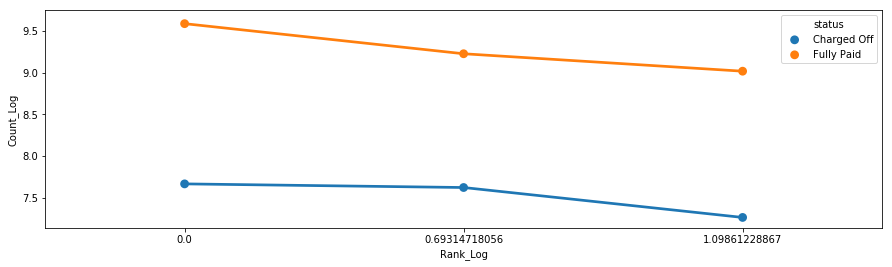

In [27]:
plt.figure(figsize=(15,4))
sns.pointplot(x="Rank_Log", y="Count_Log", hue="status", data=df_p.loc[:,['Rank_Log', 'Count_Log', 'status']])
plt.show()

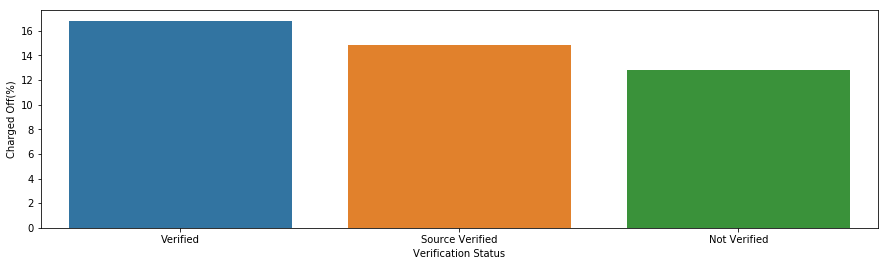

In [28]:
plt.figure(figsize=(15,4))
sns.barplot(x="verification_status", y="Charged_Off_Percent", data=verification_status_analysis)\
    .set(ylabel='Charged Off(%)', xlabel='Verification Status')
plt.show()

#### From the above analysis it is not clear than ```home_ownership``` of loan has any impact on loan.

In [29]:
loans_frame['home_ownership'].value_counts(normalize=True)

RENT       0.479
MORTGAGE   0.441
OWN        0.077
OTHER      0.003
NONE       0.000
Name: home_ownership, dtype: float64

In [30]:
home_ownership_analysis = category_univariate_analysis('home_ownership')
home_ownership_analysis

loan_status,home_ownership,Charged Off,Fully Paid,Total,Charged_Off_Percent,Fully_Paid_Percent
2,OTHER,18.000,80.000,98.000,18.367,81.633
4,RENT,2839.000,15641.000,18480.000,15.363,84.637
3,OWN,443.000,2532.000,2975.000,14.891,85.109
0,MORTGAGE,2327.000,14694.000,17021.000,13.671,86.329
1,NONE,0.000,3.000,3.000,0.000,100.000


In [31]:
df_h = power_law_df(home_ownership_analysis.loc[home_ownership_analysis['Charged Off'] != 0, :], 'home_ownership')
df_h.sort_values(by='Rank_Log')

,Rank_Log,Count_Log,home_ownership,status
1,0.000,7.951,RENT,Charged Off
5,0.000,9.658,RENT,Fully Paid
3,0.693,7.752,MORTGAGE,Charged Off
7,0.693,9.595,MORTGAGE,Fully Paid
2,1.099,6.094,OWN,Charged Off
6,1.099,7.837,OWN,Fully Paid
0,1.386,2.890,OTHER,Charged Off
4,1.386,4.382,OTHER,Fully Paid


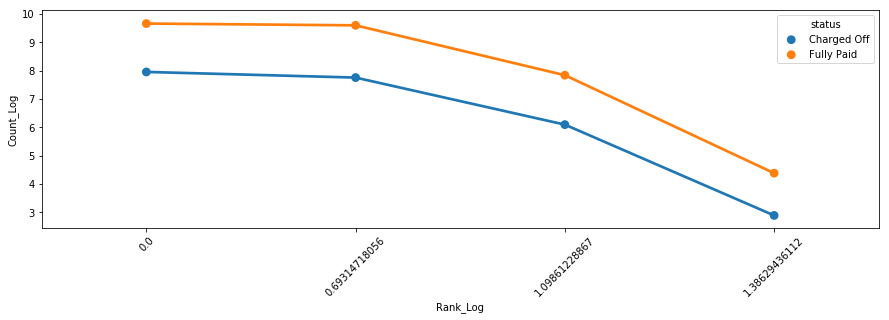

In [32]:
plt.figure(figsize=(15,4))
sns.pointplot(x="Rank_Log", y="Count_Log", hue="status", data=df_h.loc[:,['Rank_Log', 'Count_Log', 'status']])
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.show()

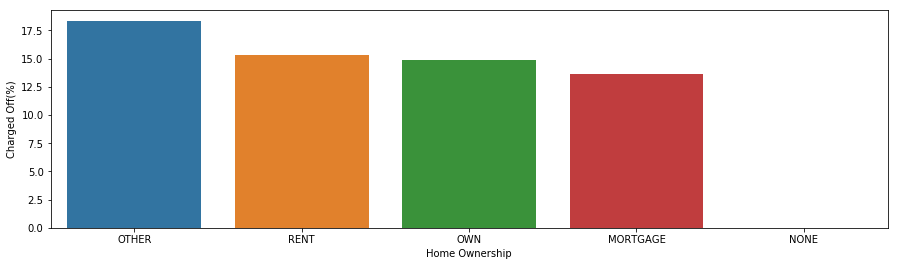

In [33]:
plt.figure(figsize=(15,4))
sns.barplot(x="home_ownership", y="Charged_Off_Percent", data=home_ownership_analysis)\
    .set(ylabel='Charged Off(%)', xlabel='Home Ownership')
plt.show()

#### From the above analysis it is not clear than ```home_ownership``` of loan has any impact on loan.

In [34]:
loans_frame['purpose'].value_counts(normalize=True)

debt_consolidation   0.468
credit_card          0.130
other                0.100
home_improvement     0.075
major_purchase       0.056
small_business       0.045
car                  0.039
wedding              0.024
medical              0.018
moving               0.015
vacation             0.010
house                0.010
educational          0.008
renewable_energy     0.003
Name: purpose, dtype: float64

In [35]:
purpose_analysis = category_univariate_analysis('purpose')
purpose_analysis

loan_status,purpose,Charged Off,Fully Paid,Total,Charged_Off_Percent,Fully_Paid_Percent
11,small_business,475,1279,1754,27.081,72.919
10,renewable_energy,19,83,102,18.627,81.373
3,educational,56,269,325,17.231,82.769
9,other,633,3232,3865,16.378,83.622
5,house,59,308,367,16.076,83.924
8,moving,92,484,576,15.972,84.028
7,medical,106,575,681,15.565,84.435
2,debt_consolidation,2767,15288,18055,15.325,84.675
12,vacation,53,322,375,14.133,85.867
4,home_improvement,347,2528,2875,12.070,87.930


In [36]:
df_pr = power_law_df(purpose_analysis, 'purpose')
df_pr.sort_values(by='Rank_Log').head()

,Rank_Log,Count_Log,purpose,status
21,0.000,9.635,debt_consolidation,Fully Paid
7,0.000,7.926,debt_consolidation,Charged Off
24,0.693,8.408,credit_card,Fully Paid
3,0.693,6.450,other,Charged Off
17,1.099,8.081,other,Fully Paid


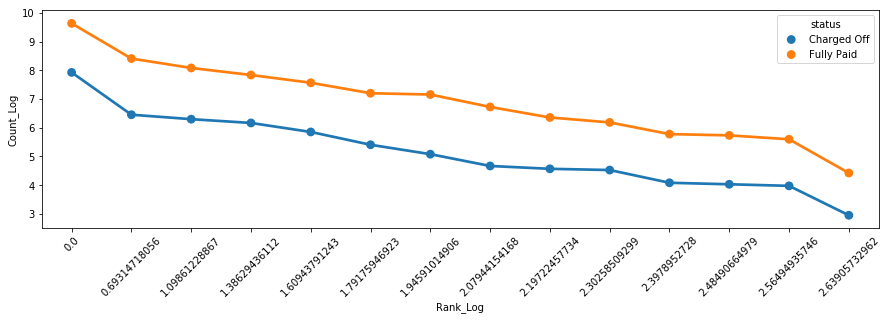

In [37]:
plt.figure(figsize=(15,4))
sns.pointplot(x="Rank_Log", y="Count_Log", hue="status", data=df_pr.loc[:,['Rank_Log', 'Count_Log', 'status']])
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.show()

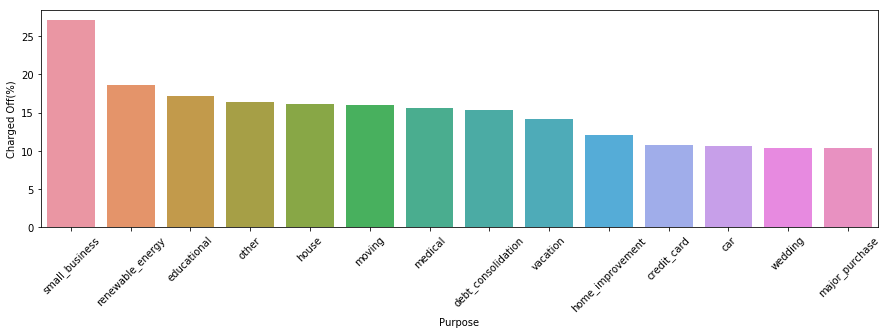

In [38]:
plt.figure(figsize=(15,4))
g = sns.barplot(x="purpose", y="Charged_Off_Percent", data=purpose_analysis)\
    .set(ylabel='Charged Off(%)', xlabel='Purpose')
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.show()

#### From the above analysis it is not clear than ```purpose``` of loan has any impact on loan default but it is interesting to loan with purpose `small business` has relatively high rate of default.

### From Lending Club public website it clear that grade, sub-grade and interest are correlated.
https://www.lendingclub.com/foliofn/rateDetail.action. Hence we are analysis grade only.

In [39]:
loans_frame['grade'].value_counts(normalize=True)

B   0.303
A   0.260
C   0.203
D   0.132
E   0.069
F   0.025
G   0.008
Name: grade, dtype: float64

In [40]:
grade_analysis = category_univariate_analysis('grade')
grade_analysis

loan_status,grade,Charged Off,Fully Paid,Total,Charged_Off_Percent,Fully_Paid_Percent
6,G,101,198,299,33.779,66.221
5,F,319,657,976,32.684,67.316
4,E,715,1948,2663,26.849,73.151
3,D,1118,3967,5085,21.986,78.014
2,C,1347,6487,7834,17.194,82.806
1,B,1425,10250,11675,12.206,87.794
0,A,602,9443,10045,5.993,94.007


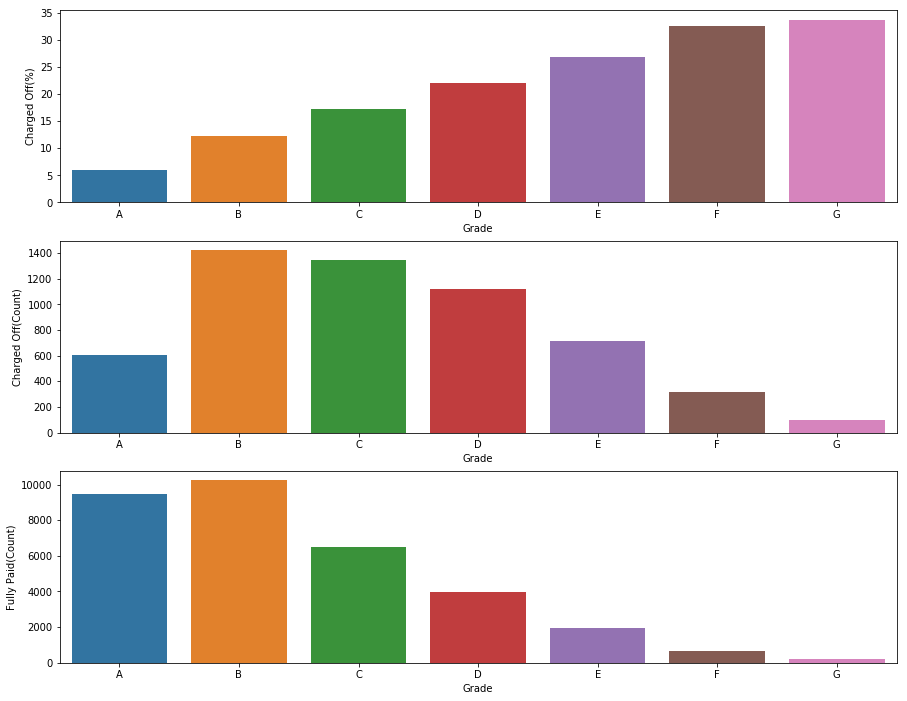

In [41]:
plt.figure(figsize=(15,12))
plt.subplot(3, 1, 1)
g = sns.barplot(x="grade", y="Charged_Off_Percent", data=grade_analysis.sort_values(by='grade'))\
    .set(ylabel='Charged Off(%)', xlabel='Grade')
    
plt.subplot(3, 1, 2)
sns.barplot(x="grade", y="Charged Off", data=grade_analysis.sort_values(by='grade'))\
    .set(ylabel='Charged Off(Count)', xlabel='Grade')

plt.subplot(3, 1, 3)
sns.barplot(x="grade", y="Fully Paid", data=grade_analysis.sort_values(by='grade'))\
    .set(ylabel='Fully Paid(Count)', xlabel='Grade')
plt.show()

#### From  above analysis it can be said the higher the grade (where G been highest and A been lowest) i.e higher the interest rate greater is the chance of loan default

In [42]:
category_univariate_analysis('sub_grade').head()

loan_status,sub_grade,Charged Off,Fully Paid,Total,Charged_Off_Percent,Fully_Paid_Percent
29,F5,54,59,113,47.788,52.212
32,G3,19,26,45,42.222,57.778
31,G2,28,49,77,36.364,63.636
28,F4,53,98,151,35.099,64.901
34,G5,10,19,29,34.483,65.517


In [43]:
loans_frame['emp_length'].value_counts(normalize=True)

10+ years   0.220
< 1 year    0.117
2 years     0.111
3 years     0.104
4 years     0.087
5 years     0.083
1 year      0.082
6 years     0.056
7 years     0.044
8 years     0.037
9 years     0.032
n/a         0.027
Name: emp_length, dtype: float64

In [44]:
emp_length_analysis = category_univariate_analysis('emp_length')
emp_length_analysis

loan_status,emp_length,Charged Off,Fully Paid,Total,Charged_Off_Percent,Fully_Paid_Percent
11,n/a,228,805,1033,22.072,77.928
1,10+ years,1331,7157,8488,15.681,84.319
7,7 years,263,1448,1711,15.371,84.629
0,1 year,456,2713,3169,14.389,85.611
5,5 years,458,2736,3194,14.339,85.661
10,< 1 year,639,3869,4508,14.175,85.825
6,6 years,307,1861,2168,14.161,85.839
8,8 years,203,1232,1435,14.146,85.854
3,3 years,555,3457,4012,13.833,86.167
4,4 years,462,2880,3342,13.824,86.176


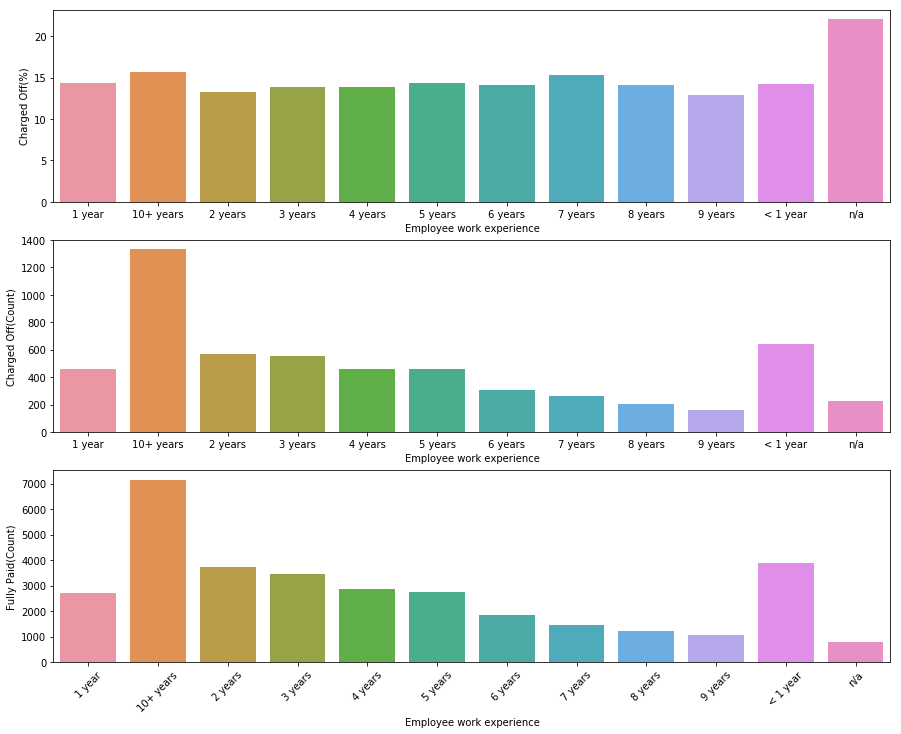

In [45]:
plt.figure(figsize=(15,12))
plt.subplot(3, 1, 1)
sns.barplot(x="emp_length", y="Charged_Off_Percent", data=emp_length_analysis.sort_values(by='emp_length'))\
    .set(ylabel='Charged Off(%)', xlabel='Employee work experience')
    
plt.subplot(3, 1, 2)
sns.barplot(x="emp_length", y="Charged Off", data=emp_length_analysis.sort_values(by='emp_length'))\
    .set(ylabel='Charged Off(Count)', xlabel='Employee work experience')

plt.subplot(3, 1, 3)
sns.barplot(x="emp_length", y="Fully Paid", data=emp_length_analysis.sort_values(by='emp_length'))\
    .set(ylabel='Fully Paid(Count)', xlabel='Employee work experience')
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.show()

 ### From  above analysis it is difficult to say employement length  has any impact on loan deaults as records which have no employment records available default most

In [46]:
loans_frame['term'].value_counts(normalize=True)

 36 months   0.754
 60 months   0.246
Name: term, dtype: float64

In [47]:
term_analysis = category_univariate_analysis('term')
term_analysis

loan_status,term,Charged Off,Fully Paid,Total,Charged_Off_Percent,Fully_Paid_Percent
1,60 months,2400,7081,9481,25.314,74.686
0,36 months,3227,25869,29096,11.091,88.909


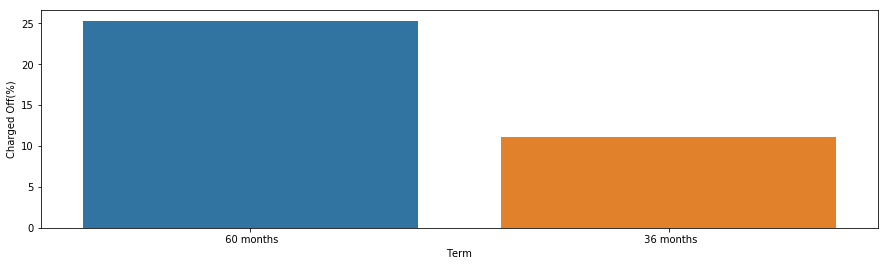

In [48]:
plt.figure(figsize=(15,4))
g = sns.barplot(x="term", y="Charged_Off_Percent", data=term_analysis)\
    .set(ylabel='Charged Off(%)', xlabel='Term')
plt.show()

#### From  above analysis it can be said the ```60 months``` term have higher change of getting defaulted.

In [49]:
loans_frame['addr_state'].value_counts(normalize=True).head()

CA   0.180
NY   0.096
FL   0.072
TX   0.069
NJ   0.046
Name: addr_state, dtype: float64

In [50]:
addr_state_analysis = category_univariate_analysis('addr_state')
addr_state_analysis.head()

loan_status,addr_state,Charged Off,Fully Paid,Total,Charged_Off_Percent,Fully_Paid_Percent
28,NE,3.000,2.000,5.000,60.000,40.000
32,NV,108.000,371.000,479.000,22.547,77.453
40,SD,12.000,50.000,62.000,19.355,80.645
0,AK,15.000,63.000,78.000,19.231,80.769
9,FL,504.000,2277.000,2781.000,18.123,81.877


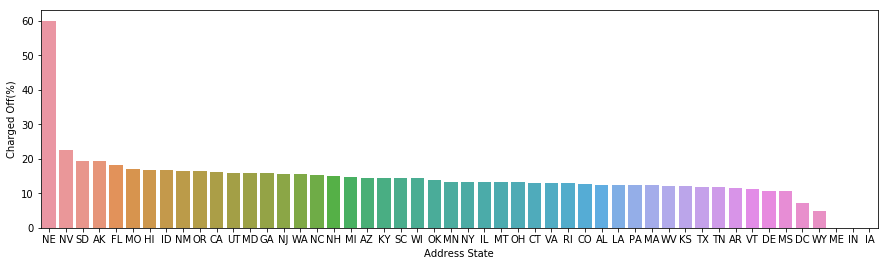

In [51]:
plt.figure(figsize=(15,4))
g = sns.barplot(x="addr_state", y="Charged_Off_Percent", data=addr_state_analysis)\
    .set(ylabel='Charged Off(%)', xlabel='Address State')
plt.show()

### From  above analysis it can be said that region has almost no impact loan default. NE has sudden spike because  it has very less number of records

## Quatitative variable univariate analysis
The whole dataset has been segmented on the basis of ```loan_status``` i.e ```Charged Off``` and ```Fully Paid```

#### A Type-driven metrics created which for  ```revol_uti```, a bucket range 10% is created to group loans as per ```revol_util``` 

In [52]:
loans_frame['revol_util'] = loans_frame['revol_util'].astype('str')
loans_frame['revol_util'] = loans_frame['revol_util'].map(lambda x : x.rstrip('%'))
loans_frame['revol_util'] = loans_frame['revol_util'].astype('float')
bins=[0,10,20,30,40,50,60,70,80,90,100]
revol_util_series = pd.cut(loans_frame.loc[loans_frame['loan_status'] == 'Charged Off','revol_util'], \
                       bins=bins).value_counts(normalize=True)

In [53]:
loans_frame['revol_util'] = loans_frame['revol_util'].astype('str')
loans_frame['revol_util'] = loans_frame['revol_util'].map(lambda x : x.rstrip('%'))
loans_frame['revol_util'] = loans_frame['revol_util'].astype('float')
bins=[0,10,20,30,40,50,60,70,80,90,100]
revol_util_fp_series = pd.cut(loans_frame.loc[loans_frame['loan_status'] == 'Fully Paid','revol_util'], \
                              bins=bins).value_counts(normalize=True)

In [54]:
s1 = revol_util_series.to_frame('Charged_Off_Percentage')
s2 = revol_util_fp_series.to_frame('Fully_Paid_Percentage')
df_u = pd.concat([s1, s2], axis=1)
df_u.reset_index(inplace=True)
df_u.rename(columns={'index': 'Revol_Util_Percentage_Range'}, inplace=True)
df_u['Charged_Off_Percentage'] = df_u['Charged_Off_Percentage'] * 100
df_u['Fully_Paid_Percentage'] = df_u['Fully_Paid_Percentage'] * 100
df_u

,Revol_Util_Percentage_Range,Charged_Off_Percentage,Fully_Paid_Percentage
0,"(0, 10]",5.359,9.930
1,"(10, 20]",6.091,9.319
2,"(20, 30]",7.573,10.247
3,"(30, 40]",9.164,10.901
4,"(40, 50]",11.085,11.269
5,"(50, 60]",11.524,11.070
6,"(60, 70]",12.054,10.771
7,"(70, 80]",12.749,9.967
8,"(80, 90]",12.402,8.992
9,"(90, 100]",11.999,7.534


##### Charged_Off_Percentage and Fully_Paid_Percentage represent the percentegae of respected `loan_status ` in the corresponding `revol_util` bucket range

In [55]:
charged_off_df = df_u.loc[:, ['Revol_Util_Percentage_Range', 'Charged_Off_Percentage']]
charged_off_df['status'] = 'Charged Off'
charged_off_df.rename(columns={'Charged_Off_Percentage': 'Percentage_Group'}, inplace=True)

fully_paid_df = df_u.loc[:, ['Revol_Util_Percentage_Range', 'Fully_Paid_Percentage']]
fully_paid_df['status'] = 'Fully Paid'
fully_paid_df.rename(columns={'Fully_Paid_Percentage': 'Percentage_Group'}, inplace=True)
fully_paid_df

chart_df = pd.concat([charged_off_df, fully_paid_df], ignore_index=True);

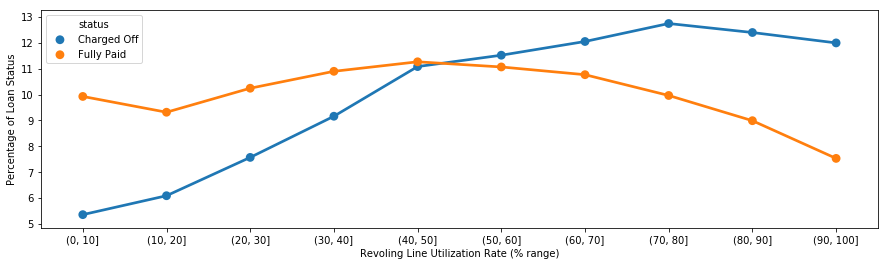

In [56]:
plt.figure(figsize=(15,4))
g = sns.pointplot(x="Revol_Util_Percentage_Range", y="Percentage_Group", hue='status', data=chart_df)\
.set(ylabel='Percentage of Loan Status', xlabel='Revoling Line Utilization Rate (% range)')
plt.show()

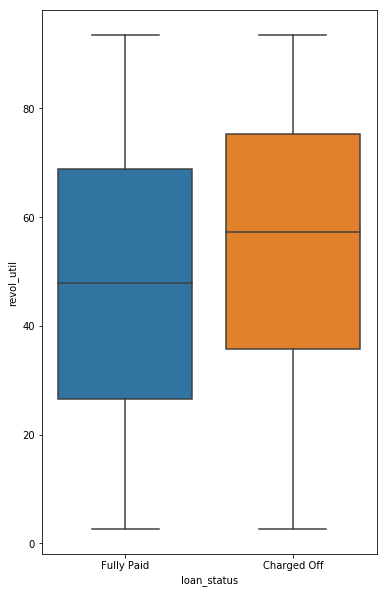

In [57]:
plt.figure(figsize=(6,10))
low, high = loans_frame.revol_util.quantile([0.05, 0.95])
ax = sns.boxplot(x="loan_status", y="revol_util", data=loans_frame[loans_frame.revol_util.between(low,high)])
plt.show()

#### From the above analysis it can be said that higher the value of this Reloving balance utility rate  , greater is the chance of loan default.
As we can see the median quite high for defaulted loans.

In [58]:
revol_bal_co = loans_frame.loc[loans_frame['loan_status'] == 'Charged Off','revol_bal'].describe()
revol_bal_co

count   5627.000  
mean    13514.244 
std     15164.117 
min     0.000     
25%     3968.000  
50%     9211.000  
75%     17518.000 
max     148829.000
Name: revol_bal, dtype: float64

In [59]:
loans_frame.loc[loans_frame['loan_status'] == 'Fully Paid','revol_bal'].describe()

count   32950.000 
mean    13251.108 
std     15983.260 
min     0.000     
25%     3603.000  
50%     8682.500  
75%     16804.750 
max     149588.000
Name: revol_bal, dtype: float64

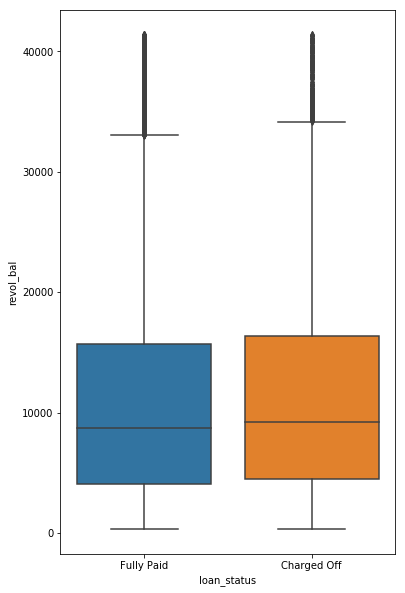

In [60]:
plt.figure(figsize=(6,10))
low, high = loans_frame.revol_bal.quantile([0.05, 0.95])
ax = sns.boxplot(x="loan_status", y="revol_bal", data=loans_frame[loans_frame.revol_bal.between(low,high)])
plt.show()

#### From the above analysis it can be said that higher the value of this Reloving balance , greater is the chance of loan default but as we can see the spread as almost equal hence the it has less impact on loan default.

In [61]:
loans_frame.loc[loans_frame['loan_status'] == 'Charged Off','dti'].describe()

count   5627.000
mean    14.001  
std     6.586   
min     0.000   
25%     9.050   
50%     14.290  
75%     19.290  
max     29.850  
Name: dti, dtype: float64

In [62]:
loans_frame.loc[loans_frame['loan_status'] == 'Fully Paid','dti'].describe()

count   32950.000
mean    13.148   
std     6.680    
min     0.000    
25%     7.980    
50%     13.200   
75%     18.390   
max     29.990   
Name: dti, dtype: float64

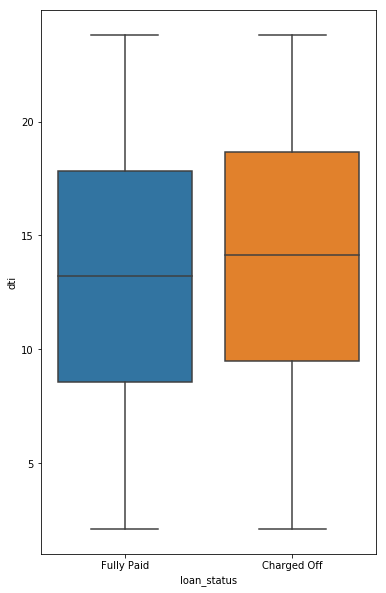

In [63]:
plt.figure(figsize=(6,10))
low, high = loans_frame.dti.quantile([0.05, 0.95])
ax = sns.boxplot(x="loan_status", y="dti", data=loans_frame[loans_frame.dti.between(low,high)])
plt.show()

#### From the above analysis it can be said that higher the value of this debt to income , greater is the chance of loan default.
We can see that defaulted loans have higher spread than the Fully paid load implying higher the value there ratio greater the risk of loan default

#### A new variable created from `open_acc` and `total_acc` ,  number of open credit account by number of closed credit accounts a Data-driven metrics. 
The idea is the lower value of this metric will imply the customer is good at paying off loans

In [64]:
loans_frame['open_closed_ratio'] = loans_frame['open_acc'] / (loans_frame['total_acc'] - loans_frame['open_acc'])
loans_frame['open_closed_ratio'].head()

0   0.500
1   3.000
2   0.250
3   0.370
5   3.000
Name: open_closed_ratio, dtype: float64

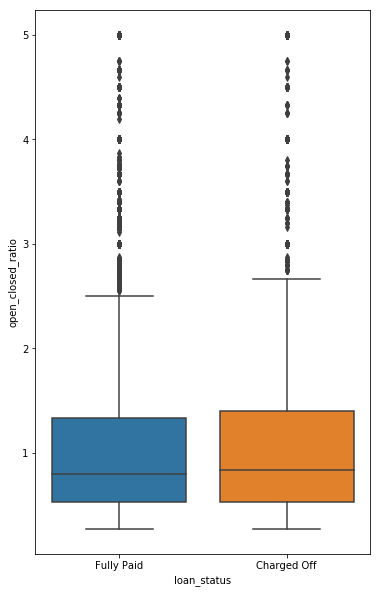

In [65]:
plt.figure(figsize=(6,10))
low, high = loans_frame.open_closed_ratio.quantile([0.05, 0.95])
ax = sns.boxplot(x="loan_status", y="open_closed_ratio", data=loans_frame[loans_frame.open_closed_ratio.between(low,high)])
plt.show()

#### From the above analysis it can be said that higher the value of this metric , greater is the chance of loan default.
We can see that defaulted loans have higher spread than the Fully paid load implying higher the value there ratio greater the risk of loan default

#### A new variable created from `earliest_cr_line` and `issue_d` , a Business-driven metrics. 
The idea is to find since when the customer is taking credit. A longer credit history means the customer is paying off loans without getting defaulted

In [66]:
def dateformat(earliest_cr_line_date):
    date_split = earliest_cr_line_date.split('-')
    if int(date_split[1]) > 18:
        date_split[1] = '19' +  date_split[1]
    else:
        date_split[1] = '20' +  date_split[1]
    return '-'.join(date_split)
loans_frame['earliest_cr_line_mod'] = loans_frame['earliest_cr_line'].apply(dateformat)

In [67]:
loans_frame['credit_history'] = round((pd.to_datetime(loans_frame['issue_d'], format='%b-%y') - \
                                pd.to_datetime(loans_frame['earliest_cr_line_mod'], format='%b-%Y')) / np.timedelta64(1, 'M'))
loans_frame['credit_history'].head()

0   323.000
1   152.000
2   121.000
3   190.000
5   85.000 
Name: credit_history, dtype: float64

In [68]:
loans_frame.loc[loans_frame['loan_status'] == 'Charged Off','credit_history'].describe()

count   5627.000
mean    161.552 
std     81.101  
min     36.000  
25%     108.000 
50%     147.000 
75%     199.000 
max     588.000 
Name: credit_history, dtype: float64

In [69]:
loans_frame.loc[loans_frame['loan_status'] == 'Fully Paid','credit_history'].describe()

count   32950.000
mean    165.205  
std     82.110   
min     36.000   
25%     109.000  
50%     150.000  
75%     204.000  
max     785.000  
Name: credit_history, dtype: float64

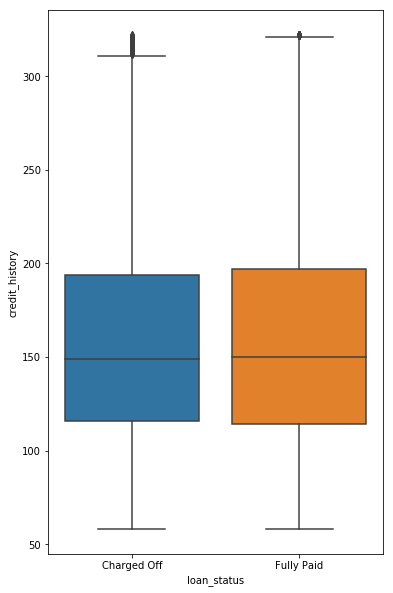

In [70]:
plt.figure(figsize=(6,10))
low, high = loans_frame.credit_history.quantile([0.05, 0.95])
ax = sns.boxplot(x="loan_status", y="credit_history", data=loans_frame[loans_frame.credit_history.between(low,high)])
plt.show()

#### From the above analysis it can be said that lower the value of this metric , greater is the chance of loan default but so high.
We can see that defaulted loans have lesser spread than the Fully paid load implying longer credit history reduces the risk of loan default

In [71]:
loans_frame.loc[:,['annual_inc','installment','revol_bal']]
loans_frame['new_debt_annual_inc_ratio'] = (loans_frame['installment'] * 12 + loans_frame['revol_bal']) /\
                                            loans_frame['annual_inc']
loans_frame['new_debt_annual_inc_ratio'].head()

0   0.650
1   0.080
2   0.324
3   0.197
5   0.273
Name: new_debt_annual_inc_ratio, dtype: float64

#### A new variable created from `annual_inc`, `installment` and `revol_bal` , a Business-driven metrics. 
The idea is loan loan repayment capacity depends on the annual income, the installment to be paid per month and the total revoling balance of the customer

In [72]:
loans_frame.loc[loans_frame['loan_status'] == 'Charged Off','new_debt_annual_inc_ratio'].describe()

count   5627.000
mean    0.298   
std     0.210   
min     0.002   
25%     0.145   
50%     0.256   
75%     0.401   
max     3.261   
Name: new_debt_annual_inc_ratio, dtype: float64

In [73]:
loans_frame.loc[loans_frame['loan_status'] == 'Fully Paid','new_debt_annual_inc_ratio'].describe()

count   32950.000
mean    0.263    
std     0.198    
min     0.001    
25%     0.120    
50%     0.215    
75%     0.355    
max     3.209    
Name: new_debt_annual_inc_ratio, dtype: float64

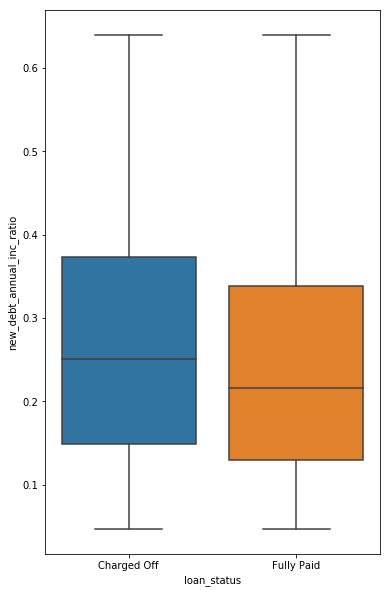

In [74]:
plt.figure(figsize=(6,10))
low, high = loans_frame.new_debt_annual_inc_ratio.quantile([0.05, 0.95])
ax = sns.boxplot(x="loan_status", y="new_debt_annual_inc_ratio", \
                 data=loans_frame[loans_frame.new_debt_annual_inc_ratio.between(low,high)])
plt.show()

#### From the above analysis it can be said that higher the value of this metric metric , greater is the chance of loan default.

In [75]:
loans_frame.shape

(38577, 43)

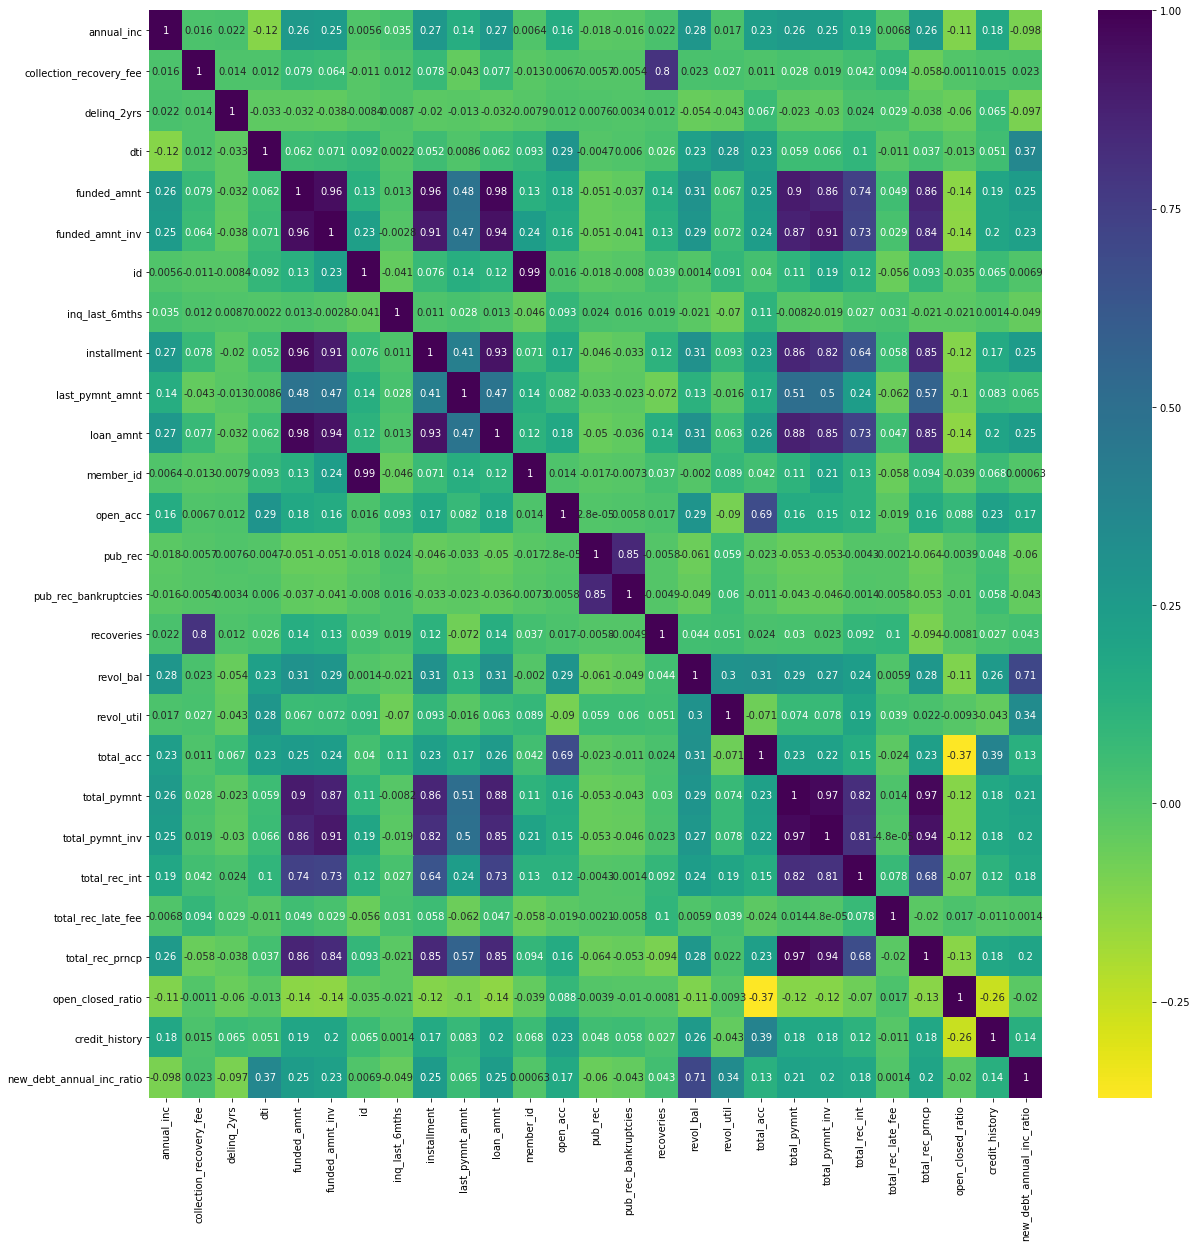

In [76]:
plt.figure(figsize = (20,20))
sns.heatmap(loans_frame.corr(),annot=True,cmap='viridis_r')
plt.show()